# Prédiction de cours boursier
-----------

![Image of Forex](https://fxmedia.s3.amazonaws.com/articles/Forex_Software-2.jpg)

L'objectif de ce mini-projet est de réaliser une prédiction de la tendance d'un cours boursier en utilisant un apprentissage supervisé. Ce projet a été réalisé dans le cadre du cours Web Semantique de l'UQAC.

On utilisera un modéle d'apprentissage ensembliste, appelé [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Bien qu'il existe d'autres méthodes pour traiter les données temporelles, ce mini-projet voulait simplement essayer de traité ce genre de problème avec des méthodes classiques de classification.

Ce mini-projet a été réalisé par Louis-Quentin Joucla.

-----------------
# Creation de la base de donnée

## 1) Obtention du cours financier

Un des objectifs de ce projet serait de tirer du bénéfice à partir de ce modéle,  il nous faut donc utiliser des données provenant de ces marchés afin d'avoir un contexte réaliste.

Afin de récupérer ces données, plusieurs techniques sont possibles:
* Webscrapper les données d'un site
* Utiliser une API Rest

Par simplicité, nous utiliserons l'API [Alpha Vantage](https://www.alphavantage.co), en plus d'obtenir les données des marchés financiers, cette API nous propose des indicateurs, qui seront très apréciables à utiliser en tant qu'attributs de note modèle.

Voici un exemple de comment effectuer une requête vers cette API en python:

In [1]:
import requests

# Clés & URL Alpha Vantage
API_KEY = "VCOM14NTWNKYH2VD"
DATA_API_URL = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symb}&outputsize=full&apikey={key}&datatype=csv"

# Formatage de la string
data_request = DATA_API_URL.format(symb="MSFT", key=API_KEY)

# Get
resp = requests.get(data_request)

# On affiche uniquement le début du contenu
print(resp.text[:200])

timestamp,open,high,low,close,volume
2018-12-21,101.6300,103.0000,97.4600,98.2300,110906155
2018-12-20,103.0500,104.3100,98.7800,101.5100,70334184
2018-12-19,103.6500,106.8800,101.3500,103.6900,681


-------
### Format de la base de donnée
Pour plus de simplicité on stockera le cours financier sous la forme d'un [DataFrame](https://pandas.pydata.org/pandas-docs/stable/dsintro.html) à l'aide de la librairie [pandas](https://pandas.pydata.org/). Cela nous permettra par la suite de manipuler nos données facilement.

Pour cela, rien de plus simple: **pandas** proprose directement de lire un fichier **.csv** pour le transformer en **Dataframe**.

In [2]:
import pandas as pd

data = pd.read_csv(data_request, index_col=0, parse_dates=True, encoding='utf-8')

# On inverse l'ordre de la dataframe pour l'avoir dans un ordre croissant en date
data = data[::-1]
data.head()

,open,high,low,close,volume
timestamp,,,,,
1998-01-02,129.63,131.50,129.50,131.13,4968500
1998-01-05,131.25,133.63,127.87,130.38,10047200
1998-01-06,129.75,133.00,129.25,131.13,8479300
1998-01-07,129.88,131.19,127.50,129.56,7686600
1998-01-08,128.63,132.13,127.50,130.50,9702400


-------
## 2) Pre-processing

### a) Labellisation des données

On se concentrera uniquement sur des prédictions à **T+1**, où **T** s'exprime en jours.

Afin de réaliser un apprentissage supervisé, il est necessaire de labéliser nos donnnées. Il est bien connu que les modéles sont plus performants en classifcation binaire, c'est pour cela que nous allons distinguer deux labels à partir de nos valeurs du cours. Si la valeur à la fermeture de marché à **T+1** est supérieure à **T**, dans ce cas c'est une augmentation, sinon c'est une baisse.

Pour la suite on attribura **0** au label augmentation et **1** au label baisse. Cela sera plus pratique pour nos opérations futures.

In [3]:
import math

# Génére le label en fonction du dictionnaire
def get_label(value):
    if math.isnan(value):
        return
    for key in labels:
        if round(value) in key:
            return labels[key]

# Dictionnaire des labels
labels = {range(0, 100): 0, range(-100, 0): 1}

# Attribution des labels et de l'évolution constaté
data['true_val'] = [x for x in ((data['close'].shift() - data['open'].shift()) / (data['high'].shift())) * 100]
data['label'] = [get_label(x) for x in ((data['close'].shift() - data['open'].shift())/(data['high'].shift()))*100]

# Permet d'enlever les lignes incomplète du dataframe
data.dropna(inplace=True)

data.head()

,open,high,low,close,volume,true_val,label
timestamp,,,,,,,
1998-01-05,131.25,133.63,127.87,130.38,10047200,1.140684,0.0
1998-01-06,129.75,133.00,129.25,131.13,8479300,-0.651051,1.0
1998-01-07,129.88,131.19,127.50,129.56,7686600,1.037594,0.0
1998-01-08,128.63,132.13,127.50,130.50,9702400,-0.243921,0.0
1998-01-09,130.06,131.50,125.87,127.00,10941800,1.415273,0.0



On regarde alors la répartion des labels sur l'ensemble de notre base de donnée :

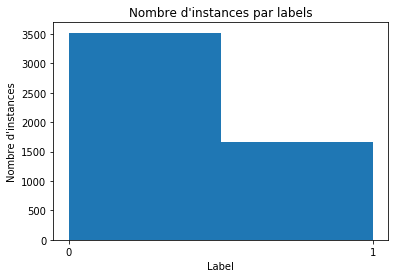

In [17]:
import matplotlib.pyplot as plt
# Generation de l'histogramme
label_repart = plt.hist(data['label'], bins=2, histtype='bar')

# Titres
plt.title('Nombre d\'instances par labels')
plt.xlabel("Label")
plt.ylabel("Nombre d'instances")

# Limite des axes
plt.xticks(range(0, 2))

# Affiche le graphique
plt.show()

On remarque alors un déséquilibre dans la proportion des classes. Cela peut poser un problème dans le sens où le modèle aura tendance à plus apprendre en fonction de la classe majoritaire au détriment de la classe minoritaire.

Il existe plusieurs techniques pour pallier à ces soucis tels que l'[oversampling](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html), l'[undersampling](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html).


On étudiera l'impact de ces deux méthodes de resampling sur nos résultats.



### b) Selection et calculs des attributs

Les données étant temporelles, il est nécessaire de prendre cet aspect en considération dans notre modèle. Mais il ne faut pas oublier que les cours boursiers auront tendances à avoir des comportement différents selon les périodes.

On décide alors de calculer les attributs suivants:

* **La moyenne mobile**

La moyenne mobile, ou moyenne glissante, est un type de moyenne statistique utilisée pour analyser des séries ordonnées de données, le plus souvent des séries temporelles, en supprimant les fluctuations transitoires de façon à en souligner les tendances à plus long terme.

*On la calculera sur une période de 50 jours.*

* **Les bandes de Bollinger**

Les bandes de Bollinger sont un outil d'analyse économique développé par John Bollinger. Elles sont utilisées en finance de marché pour des analyses techniques et permettent d'évaluer la volatilité et l'évolution probable de prix ou d'indices.

*On la calculera sur une période de 10 jours.*

* **Relative strength index**

Proposé par J. Welles Wilder1 en 1978, le RSI (Relative Strength Index) est un indicateur avancé d'analyse technique. Utilisé conjointement à l'analyse de la tendance, il a vocation à :
    - Repérer la puissance d'un mouvement (indiquer si le mouvement s'essouffle)
    - Indiquer si l'on est en situation de sur-achat ou de sur-vente
    
*On la calculera sur une période de 50 jours.*

* **Commodity Channel Index**

Tout comme le RSI, le CCI nous montre les situations de surachat (avec un CCI élevé) et celles de surventes (avec un CCI faible) pour une unité de temps. Il nous permet également l'étude des divergences avec un cours.

*On la calculera sur une période de 50 jours.*

----
De plus, pour chacunes des instances, pour renforcer l'importance de la temporalité, on incluera selon la taille N de la fenêtre choisi par l'utilisateur, les N-ième valeurs des attributs précédents dans les features de l'instance.

Par exemple pour une instance la valeur **CLOSE_S1**, représentera la valeur de fermeture de l'instance précédente, **CLOSE_S2** sera la valeur de fermeture de l'instance à **T-2**, et ainsi de suite...


In [5]:
import numpy as np

FEATURE_URL = "https://www.alphavantage.co/query?function={feature}&symbol={symb}&interval=daily&time_period=50&series_type=open&apikey={key}&datatype=csv"
WINDOW_SIZE = range(1, 3)

def get_features(dataframe, symbol, feature):
    data_request = FEATURE_URL.format(symb=symbol, feature=feature, key=API_KEY)
    resp = pd.read_csv(data_request, index_col=0, parse_dates=True, encoding='utf-8')
    resp = resp[::-1]
    new_df = pd.concat([dataframe, resp], axis=1)
    new_df.dropna(inplace=True)
    return new_df


def compute_features(df):
    df['MA_50'] = df['close'].rolling(window=50).mean()
    df['MA_10'] = df['close'].rolling(window=10).mean()
    df['std'] = (df['MA_10'] - df['close']) * (df['MA_10'] - df['close'])
    df['std'] = df['std'].apply(np.sqrt)
    df['H_BOL'] = df['std'] + df['MA_10']
    df['L_BOL'] = -1 * df['std'] + df['MA_10']
    df.dropna(inplace=True)
    

data = get_features(data, "MSFT", "RSI")
data = get_features(data, "MSFT", "CCI")
compute_features(data)


data.head()

,open,high,low,close,volume,true_val,label,RSI,CCI,MA_50,MA_10,std,H_BOL,L_BOL
1998-05-27,82.87,86.12,82.87,86.00,14643600.0,-1.960784,1.0,41.5874,-75.3075,88.2184,86.518,0.518,87.036,86.000
1998-05-28,85.75,86.37,85.06,86.31,7686700.0,3.634464,0.0,42.9497,-58.3204,88.3372,86.455,0.145,86.600,86.310
1998-05-29,86.37,86.50,84.75,84.81,8522800.0,0.648373,0.0,43.2405,-76.8434,88.3984,86.042,1.232,87.274,84.810
1998-06-01,83.87,84.61,83.12,83.75,10609200.0,-1.803468,1.0,42.3523,-119.0734,88.4334,85.473,1.723,87.196,83.750
1998-06-02,84.06,85.94,83.87,85.50,9642700.0,-0.141827,0.0,42.4440,-89.7170,88.5072,85.417,0.083,85.500,85.334


In [6]:
def make_dataset(df):
    new_df = df.copy()
    base_features = ['close', 'volume', 'L_BOL', 'H_BOL', 'RSI', 'MA_50']
    for i in WINDOW_SIZE:
        new_df['H_BOL_S'+str(i)] = df['H_BOL'].shift(i)
        new_df['L_BOL_S'+str(i)] = df['L_BOL'].shift(i)
        new_df['MA_50_S'+str(i)] = df['MA_50'].shift(i)
        new_df['CCI_S'+str(i)] = df['CCI'].shift(i)
        new_df['RSI_S' + str(i)] = df['RSI'].shift(i)
        new_df['CLOSE_S'+str(i)] = df['close'].shift(i)
        new_df['VOLUME_S'+str(i)] = df['volume'].shift(i)

        base_features.extend(['H_BOL_S'+str(i), 'L_BOL_S'+str(i), 'MA_50_S'+str(i), 'CCI_S'+str(i),'RSI_S' + str(i),
                              'CLOSE_S' + str(i), 'VOLUME_S'+str(i)])

    new_df.reset_index(inplace=True)
    new_df.dropna(inplace=True)
    return new_df, base_features


dataset, features = make_dataset(data)
dataset.head()

,index,open,high,low,close,volume,true_val,label,RSI,CCI,...,RSI_S1,CLOSE_S1,VOLUME_S1,H_BOL_S2,L_BOL_S2,MA_50_S2,CCI_S2,RSI_S2,CLOSE_S2,VOLUME_S2
2,1998-05-29,86.37,86.50,84.75,84.81,8522800.0,0.648373,0.0,43.2405,-76.8434,...,42.9497,86.31,7686700.0,87.036,86.000,88.2184,-75.3075,41.5874,86.00,14643600.0
3,1998-06-01,83.87,84.61,83.12,83.75,10609200.0,-1.803468,1.0,42.3523,-119.0734,...,43.2405,84.81,8522800.0,86.600,86.310,88.3372,-58.3204,42.9497,86.31,7686700.0
4,1998-06-02,84.06,85.94,83.87,85.50,9642700.0,-0.141827,0.0,42.4440,-89.7170,...,42.3523,83.75,10609200.0,87.274,84.810,88.3984,-76.8434,43.2405,84.81,8522800.0
5,1998-06-03,85.87,86.44,84.12,84.31,9002700.0,1.675588,0.0,43.3202,-95.9363,...,42.4440,85.50,9642700.0,87.196,83.750,88.4334,-119.0734,42.3523,83.75,10609200.0
6,1998-06-04,84.69,86.12,83.62,86.06,8429400.0,-1.804720,1.0,42.8859,-88.4545,...,43.3202,84.31,9002700.0,85.500,85.334,88.5072,-89.7170,42.4440,85.50,9642700.0


### Graphique

Pour s'assurer de la qualité de nos features, on affiche le graphique du cours boursier avec nos attributs, afin d'avoir une idée de la pertinence des attributs:

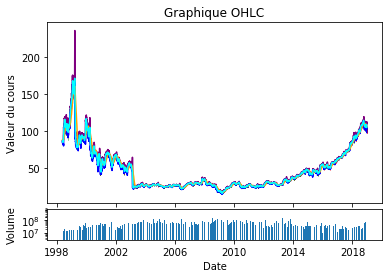

In [7]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
%matplotlib inline

test_frame = data.copy()
test_frame.reset_index(inplace=True)
test_frame['timestamp'] = test_frame[test_frame.columns[0]]
test_frame.timestamp = [x.to_pydatetime() for x in test_frame.timestamp]
test_frame.timestamp = test_frame.timestamp.map(mdates.date2num)

ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)
ax1.xaxis_date()

test = zip(test_frame.timestamp, test_frame.open, test_frame.high, test_frame.low, test_frame.close)

candlestick_ohlc(ax1, test, width=1, colorup='g', colordown='r')

ax1.plot(test_frame['timestamp'], test_frame['H_BOL'], color='purple')
ax1.plot(test_frame['timestamp'], test_frame['L_BOL'], color='blue')
ax1.plot(test_frame['timestamp'], test_frame['MA_50'], color='orange')
ax1.plot(test_frame['timestamp'], test_frame['MA_10'], color='cyan')

ax2.bar(test_frame.timestamp, test_frame['volume'])
ax2.set_yscale('log')

ax1.set_title('Graphique OHLC')
ax1.set_ylabel("Valeur du cours")
ax2.set_ylabel("Volume")
ax2.set_xlabel("Date")

plt.show()

-----
# Entrainement et tests

Pour faire nos prédictions nous allons utiliser un Random Forest Classifier. C'est un modéle qui combine plusieurs Decision Tree classifiers en utlisant des techniques de Bagging et de selection des attributs.

Les décisions tree discriminant les features par entropie, il n'est pas necessaire de normaliser nos features.
On séparera notre base de donnée en deux parties, un **training set** (**90%**) et un **test set** (**10%**). On ne mélange pas les données afin de garder une cohérence temporelle.

On règle de manière empirique les hypers-paramètres de notre Random Forest, puis on l'entraine et le test.

----
# Evaluation #

Pour evaluer notre modéle on utilisera les metrics suivantes:

* [Precision](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
* [Recall](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
* [F1-score](https://en.wikipedia.org/wiki/F1_score)


----
# Resultats

## 1) Sans re-échantillonnage

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Separation 90/10 %
X_train, X_test, y_train, y_test = \
    train_test_split(dataset[features],
                            dataset['label'], test_size=0.1, random_state=False, shuffle=False)


# Creation model & réglages hyper-paramètres
model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0, max_features='sqrt')

# Entrainement
model.fit(X_train, y_train)

# Test
predict = model.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, predict)
cf_matrix = confusion_matrix(y_test, predict)
report = classification_report((y_test.values).astype(int), (predict).astype(int))

acc

0.805019305019305

Normalized confusion matrix
[[0.88372093 0.11627907]
 [0.42748092 0.57251908]]


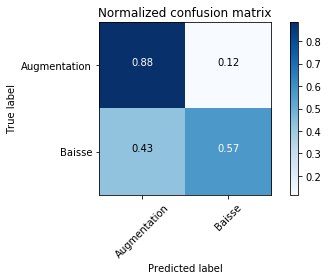

In [9]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
plt.figure()
plot_confusion_matrix(cf_matrix, classes=['Augmentation', 'Baisse'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()


In [10]:
print(report)

             precision    recall  f1-score   support

          0       0.86      0.88      0.87       387
          1       0.62      0.57      0.60       131

avg / total       0.80      0.81      0.80       518



## 2) Avec over-sampling

Il faut uniquement appliquer l'over-sampling sur les données d'entrainements ! On ne va pas évaluer la qualité de notre modèle sur des données générés synthétiquement.

On va d'abord regarder l'impact de l'over-sampling sur nos classes :

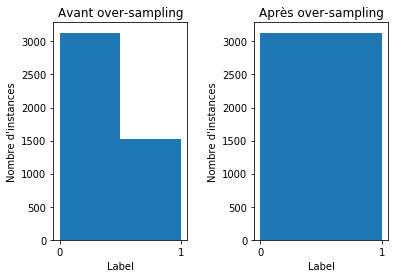

In [11]:
# Resampling
X_train_os, y_train_os = RandomOverSampler().fit_sample(X_train, y_train)


# Titres
plt.subplot(1,2,1)
plt.title('Avant over-sampling')
plt.xlabel("Label")
plt.ylabel("Nombre d'instances")
plt.hist(y_train, bins=2, histtype='bar')

# Limite des axes
plt.xticks(range(0, 2))

# Titres
plt.subplot(1,2,2)
plt.title('Après over-sampling')
plt.xlabel("Label")
plt.ylabel("Nombre d'instances")
plt.hist(y_train_os, bins=2, histtype='bar')

# Limite des axes
plt.xticks(range(0, 2))
plt.subplots_adjust(wspace=0.5)

# Affiche le graphique
plt.show()



Normalized confusion matrix
[[0.77777778 0.22222222]
 [0.35877863 0.64122137]]


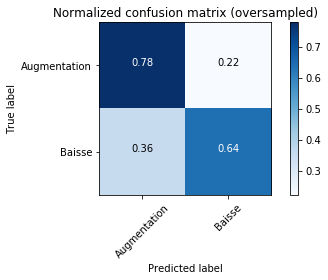

In [12]:
# Creation model & réglages hyper-paramètres
model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0, max_features='sqrt')

# Entrainement
model.fit(X_train_os, y_train_os)

# Test
predict = model.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, predict)
cf_matrix = confusion_matrix(y_test, predict)
report = classification_report((y_test.values).astype(int), (predict).astype(int))

plot_confusion_matrix(cf_matrix, classes=['Augmentation', 'Baisse'], normalize=True,
                      title='Normalized confusion matrix (oversampled)')

In [13]:
print(report)

             precision    recall  f1-score   support

          0       0.86      0.78      0.82       387
          1       0.49      0.64      0.56       131

avg / total       0.77      0.74      0.75       518



## 2) Avec under-sampling

Comme pour l'over-sampling, il faut appliquer uniquement l'under-sampling sur les données d'entrainements ! On ne va pas évaluer la qualité de notre modèle sur des données générés synthétiquement.

On va d'abord regarder l'impact de l'under-sampling sur nos classes :

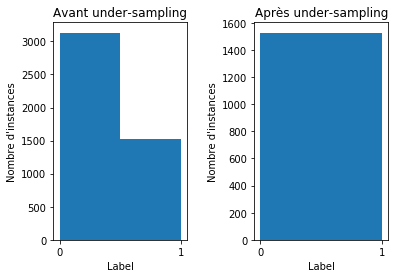

In [14]:
# Resampling
X_train_us, y_train_us = RandomUnderSampler().fit_sample(X_train, y_train)


# Titres
plt.subplot(1,2,1)
plt.title('Avant under-sampling')
plt.xlabel("Label")
plt.ylabel("Nombre d'instances")
plt.hist(y_train, bins=2, histtype='bar')

# Limite des axes
plt.xticks(range(0, 2))

# Titres
plt.subplot(1,2,2)
plt.title('Après under-sampling')
plt.xlabel("Label")
plt.ylabel("Nombre d'instances")
plt.hist(y_train_us, bins=2, histtype='bar')

# Limite des axes
plt.xticks(range(0, 2))
plt.subplots_adjust(wspace=0.5)

# Affiche le graphique
plt.show()


Normalized confusion matrix
[[0.42635659 0.57364341]
 [0.09160305 0.90839695]]


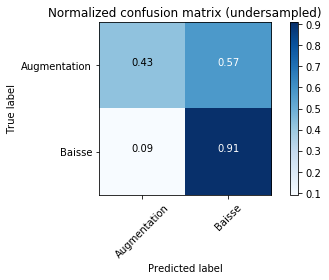

In [15]:
# Creation model & réglages hyper-paramètres
model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0, max_features='sqrt')

# Entrainement
model.fit(X_train_us, y_train_us)

# Test
predict = model.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, predict)
cf_matrix = confusion_matrix(y_test, predict)
report = classification_report((y_test.values).astype(int), (predict).astype(int))

plot_confusion_matrix(cf_matrix, classes=['Augmentation', 'Baisse'], normalize=True,
                      title='Normalized confusion matrix (undersampled)')

In [16]:
print(report)

             precision    recall  f1-score   support

          0       0.93      0.43      0.59       387
          1       0.35      0.91      0.50       131

avg / total       0.78      0.55      0.56       518



----
## Influence de l'échantillonnage

Globalement le modéle sans re-échantillonnage fonctionne mieux. Cela peut s'expliquer facilement du fait que dans le cas de l'undersampling on perd une quantité importante de données, et dans le cas de l'oversampling les données générés aléatoirement ne sont pas de bonne qualité. Ce qui est normal car il est plus difficile de générer synthétiquement des données avec une dépendance temporelle.

Cependant si on cherche à se faire du bénéfice, le modéle undersampled semble la meilleure option, car même si le modèle a un taux de faux-négatifs élevé (ce qui signifie un manque à gagner si l'on veut investir sur des augmentations), le taux de faux-positifs est très faible. Si on regarde la matrice de confusion, sur 56 cas (11 + 45), on se trompera sur 11 cas mais on fera un bon pari sur 45 cas, soit une différence de 34. Bien évidemment il faut nuancer, cela dépends de la valeur réel des augmentations et des baisses.

----
# Conclusion

Les cours boursiers sont des courbes difficiles à prédire. Les marchés fonctionnent par période, ce qui les rends parfois imprévisibles pour du machine-learning. Ces cours étant soit à la hausse, soit à la baisse, cela va donc forcemment généré des classes déséquilibrées.

L'approche par Random Forest semble intéressante, grâce à ces technniques de bagging et de selections d'attributs elle permet de mieux interpréter les changements des cours boursiers. Cependant ce n'est pas le meilleur modéle pour prendre en compte l'aspect temporel. Il serait intéréssant de tester d'autres modèles tels que les réseaux de neurones récurrents. On pourrait aussi considérer d'autres approches tels que les timeseries.

Cependant les résultats semblent encourageant. Il faudrait alors trouver une façon optimale de re-échantillonner les données. De plus il faudrait trouver un moyen pour plus prendre en compte l'aspect changeant des cours boursiers selon la période.
